<a href="https://colab.research.google.com/github/sunghyouk/study_room/blob/master/self_ML_DL_study_text/ch7_3_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# fashione MNIST 불러오기
from tensorflow import keras
(train_input, train_target), (test_input, test_target) = \
keras.datasets.fashion_mnist.load_data()

In [7]:
from sklearn.model_selection import train_test_split
train_scaled = train_input / 255.0 # regularization
# train_scaled = train_scaled.reshape(-1, 28*28) # 가로, 세로 2차원을 1차원으로 만들기: flatten으로 쉽게 가능
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [8]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [9]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


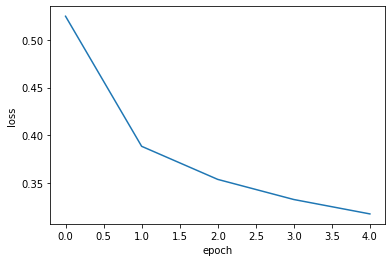

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()